<a href="https://colab.research.google.com/github/mwithgod3952/Machine_Learning_Theory_jh/blob/master/Autoencode%EB%A5%BC_%ED%86%B5%ED%95%9C_image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive; drive.mount("/content.drive", force_remount=True)

Mounted at /content.drive


In [2]:
import os

In [4]:
imgs_dir = "/content/drive/MyDrive/pr_image_similarity_with_dense_net/train"
img_path_lst = os.listdir(imgs_dir)

In [4]:
# for i in range(len(img_path_lst)):
#     new_name = f"row_{os.listdir(imgs_dir)[i].split('_')[0]}_{os.listdir(imgs_dir)[i]}"
#     os.rename(imgs_dir + "/" +  os.listdir(imgs_dir)[i], imgs_dir + "/" + new_name)

In [5]:
img_path_lst = os.listdir(imgs_dir)
img_path_lst[-5: ]

['032fac6b9.jpg',
 '034b31ef4.jpg',
 '039533860.jpg',
 '03056d2b8.jpg',
 '034e5fe12.jpg']

In [6]:
print("training data length : ", len(img_path_lst))

training data length :  25362


---

In [7]:
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pandas.util.testing as tm

# Part of Visualization 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cv2
import imageio as io
from pylab import *
from sklearn.manifold import TSNE

# Model Performance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals import joblib

# Model training
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image

import tensorflow as tf

from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [8]:
train_files, test_files = train_test_split(img_path_lst, test_size = 0.15)

In [9]:
print("the length of train dataset", len(train_files), " / "
      "the length of test dataset", len(test_files))

the length of train dataset 21557  / the length of test dataset 3805


In [23]:
train_files = pd.DataFrame(train_files, columns=['dir'])
test_files = pd.DataFrame(test_files, columns=['dir'])

# Make train, test csv files
train_files.to_csv('/content/drive/My Drive/train_file.csv')
test_files.to_csv('/content/drive/My Drive/test_file.csv')

# Import train, test csv files
train_files = pd.read_csv('/content/drive/MyDrive/train_file.csv')
test_files  = pd.read_csv('/content/drive/MyDrive/test_file.csv')

# Save the file path information to the list
train_files = list(train_files.iloc[:,1])
test_files = list(test_files.iloc[:,1])

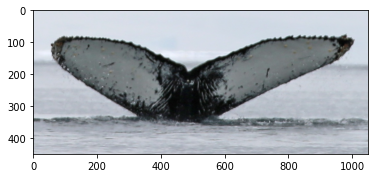

In [32]:
img = cv2.imread('/content/drive/MyDrive/pr_image_similarity_with_dense_net/train/'+train_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

***Image load***

In [35]:
def image_to_array(file_array):
    image_array = []

    for path in tqdm(file_array):
        img = cv2.imread('/content/drive/MyDrive/pr_image_similarity_with_dense_net/train/' + path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        image_array.append(np.array(img))

    image_array = np.array(image_array)
    image_array = image_array.reshape(image_array.shape[0], 224, 224, 3) 
    print("reshape_encoded img", image_array)
    image_array = image_array.astype('float32')
    image_array /= 255
    print("/", image_array)
    return np.array(image_array)

In [ ]:
train_data = image_to_array(train_files)
test_data  = image_to_array(test_files )